# Week 1 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slightly to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "C:/Users/Thinkpad/ContentAnalysis/Content-Analysis-2020/week-1/Movies"

#corpus_name = "Movies"

This method extracts the text from the zip files and stores the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

Let's look at what the code chunk above does. 

First, `def` function literally defines a function. You can call the function that you defined by using the function name, which is, here, loadcorpus. 

Second, it might be obvious, but, in Python, + operator is used when you combine literal strings or string variables. So, "corpus_name" + "/" gets you "corpus_name/". For example, in my case, the corpus_name is 'Users/hyunkukwon/Downloads/Movies'; so, corpus_name + "/" gives me '/Users/hyunkukwon/Downloads/Movies/'. By the way, why do we use "" here? This is because / is an operator in itself. Using "" makes / a string rather than an operator. Just to let you know, you can use `type()` to see what's the type of something. For example, if you write `type(corpus_name)`, it'll get you 'string'.

Third, the `os.listdir` function is used to get the list of files in the specified directory. So, here we're trying to get all the files in the directory. 

But we have some problems here: 

(1) first problem is that we do not want to load all the files in this directory; we want to load the files that have 'text' in the file name. So, we use the "if corpus_style in file:" to get the files that have the textual characteristics that we specified when we defined the function (`corpus_style = "text"`). Just to clarify, specifying the corpus_style does not get us the txt. files (in other words, it's not about the file extension). 

(2) second problem is that the files we have are zip files. So, we should unzip it so that we can get them on Python. That's why we use ZipFile, a class of zipfile module. We use ZipFile to read and write zip files. Then we use `namelist()` function, which returns the list of archive members by name.

Finally, `append()` function adds an item at the end of the list. Here, we make an empty list by doing "texts_raw[file] = []"; and then we open the file, get every line in the file, and then append it to the empty list. The for loop does the iteration. 

By the way, we used something similar above: `texts_raw = {}`. But they're different: `{}` is a dictionary, while `[]` is a list. 

In [4]:
movie_raw = loadcorpus(corpus_name)

text_00_myn.zip
text_01_ote.zip
text_02_mqu.zip
text_03_mnq.zip
text_04_mlq.zip
text_05_nko.zip
text_06_jfy.zip
text_07_oma.zip
text_08_loh.zip
text_09_oii.zip
text_10_aoy.zip
text_11_uoy.zip
text_12_rcq.zip
text_13_idi.zip
text_14_lnc.zip
text_15_guo.zip
text_16_qll.zip
text_17_arp.zip
text_18_jfj.zip
text_19_gvc.zip
text_20_cde.zip
text_21_fqa.zip
text_22_etp.zip
text_23_fmh.zip
text_24_ywo.zip
text_25_byg.zip
text_26_ngj.zip
text_27_fle.zip
text_28_rfy.zip
text_29_oye.zip
text_30_wkp.zip
text_31_akv.zip
text_32_ldf.zip
text_33_kje.zip


Why do we get this list of files? Because of the `print(file)` in the code chunk above. So, the list here involves all the files that have "text" in their file name. 

Let's look at one of the files:

In [5]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

Now we're familiar with the code structure (such as for loop) as well as some functions (such as `append()`). Let's briefly look at the functions that didn't appear above.

`replace()` is a Python built-in function for strings. What it does is: it replaces the one that comes before with the one that comes later. The syntax of this function is the following: `str.replace(old, new[, max])`. The `[, max]` part is optional, and we didn't use it here. For example, `text.replace(" \'m", "'m")` literally replaces /'m with 'm. 

`decode()` is a function which literally converts from one encoding scheme to the other one.

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using `spaCy` to do some heavier cleaning. `spaCy` does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [9]:
nlp = spacy.load("en_core_web_sm")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

Let's look at the cell above. What are we doing here? We want to tokenize the corpus, i.e. split the text into minimal meaningful units. To do so, we collect tokens in the document that is neither punctuation (e.g. "?", ",", "!" etc) nor the ones the length of which is not bigger than 0. `is_punct` tells you if a token is a punctuation or not; so, we use "if not" to weed out punctuations. len(token.text.strip()) gets you the length of each string; so, we remove strings the length of which is not bigger than 0. By the way, `strip()` function here returns a copy of the wtring with both leading and trailing characters stripped. Since we didn't specify any characters, it merely removes the spaces before and after each string.

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

What's going on here? We first make an empty dictionary (by the way, if you're not familiar with dictionaries, you should go look it up online.) Then, we go through each word in the word list one by one with the for loop. If the word that the loop is looking at has appeared before, we add one more to the number(`+= 1`); if it didn't appear before, we assign one to the word (`= 1`). 

And then we convert it to DataFrame. Why do we use `wordCounts.items()` here? Because the wordCounts that we defined above is a dictionary; and `items()` returns the list of all dictionary keys with values. And then we use pandas.DataFrame to convert this dictionary to DataFrame.

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,word,count
0,@@216680,1
1,hey,16
2,i,191
3,'m,24
4,talking,2
5,to,112
6,you,302
7,give,14
8,me,82
9,600,1


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,word,count
6,you,302
2,i,191
13,'s,126
5,to,112
31,it,109
...,...,...
248,postman,10
187,please,9
328,but,9
215,as,9


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

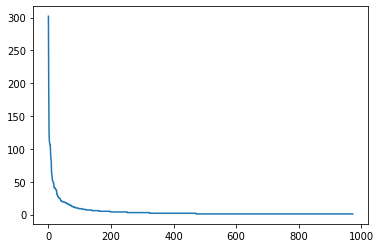

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

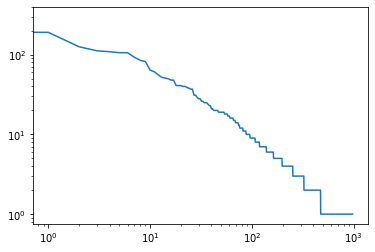

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in a few weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [17]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [18]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [19]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [20]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [21]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [22]:
import nltk

In [23]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [24]:
whText.common_contexts(['stem'])

for_cell hope_cell time_cell own_cells joints_cell of_cell on_cells
the_cell embryonic_cells


We can also just count the number of times the word occurs.

In [25]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

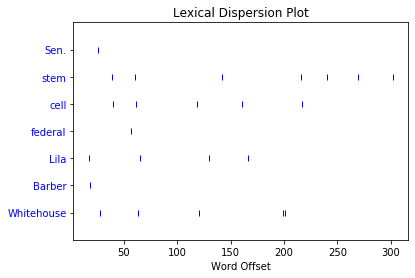

In [26]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [27]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [28]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [29]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [30]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

But before we proceed: what is the lambda function here? What the lambda function does here is that it iterates over the list row by row and applies the function, e.g. word_tokenize() or len(), to each list. So, it looks similar to for loop; but, lambda is an expression while for loop is a statement. I won't elaborate on the difference between these two here for space limitations. 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

I use the FOMC Minutes from 2007 to 2010 to examine whether the crisis had significantly changed the believes of the central bankers on the economic perspectives and their corresponding policy responses. 

In [31]:
#Load texts in .txt of the same category to one item
def load_corpus_from_txt(corpus_name):
    texts_raw = []
    for file in os.listdir(corpus_name + "/"):
        with open(corpus_name + '/' + file, encoding="utf8", errors='ignore') as f:
            for line in f:
                texts_raw.append(line)
    return texts_raw

In [32]:
Minutes_pre_txt = r"C:\Users\Thinkpad\ContentAnalysis\Content-Analysis-2020\week-1\FOMC_pre"
Minutes_post_txt = r"C:\Users\Thinkpad\ContentAnalysis\Content-Analysis-2020\week-1\FOMC_post"

pre_raw = load_corpus_from_txt(Minutes_pre_txt)
post_raw = load_corpus_from_txt(Minutes_post_txt)

In [33]:
pre_raw[:5]

['In the agenda for this meeting, it was reported that advices of the election of the following members and alternate members of the Federal Open Market Committee for a term beginning January 30, 2007 had been received and that these individuals had executed their oaths of office.\n',
 '\n',
 'The elected members and alternate members were as follows:\n',
 '\n',
 'Timothy F. Geithner, President of the Federal Reserve Bank of New York, with Christine M. Cumming, First Vice President of the Federal Reserve Bank of New York, as alternate.\n']

In [34]:
post_raw[:5]

["The Manager of the System Open Market Account reported on recent developments in foreign exchange markets. There were no open market operations in foreign currencies for the System's account in the period since the previous meeting. The Manager also reported on developments in domestic financial markets and on System open market operations in government securities and federal agency obligations during the period since the previous meeting. By unanimous vote, the Committee ratified these transactions.\n",
 '\n',
 'The information reviewed at the December meeting pointed to a significant contraction in economic activity in the fourth quarter. Conditions in the labor market deteriorated considerably in recent months as most major industry groups shed jobs. Private payrolls continued to fall at a faster pace than earlier in the year, and the unemployment rate rose to 6.7 percent. Industrial production, excluding special hurricane- and strike-related effects, fell further in November, and

In [35]:
# Since my raw texts are not so messy, here I only delete \n's, \t's and empty strings
def delete_newline_empty(raw_texts):
    clean_texts = []
    for text in raw_texts:
        clean_text = text.replace("\n", "").replace("\t", " ")
        if clean_text:
            clean_texts.append(clean_text)
    return clean_texts

In [36]:
pre_clean = delete_newline_empty(pre_raw)
post_clean = delete_newline_empty(post_raw)

In [37]:
pre_clean[:5]

['In the agenda for this meeting, it was reported that advices of the election of the following members and alternate members of the Federal Open Market Committee for a term beginning January 30, 2007 had been received and that these individuals had executed their oaths of office.',
 'The elected members and alternate members were as follows:',
 'Timothy F. Geithner, President of the Federal Reserve Bank of New York, with Christine M. Cumming, First Vice President of the Federal Reserve Bank of New York, as alternate.',
 'Cathy E. Minehan, President of the Federal Reserve Bank of Boston, with Charles I. Plosser, President of the Federal Reserve Bank of Philadelphia, as alternate.',
 'Michael H. Moskow, President of the Federal Reserve Bank of Chicago, with Sandra Pianalto, President of the Federal Reserve Bank of Cleveland, as alternate.']

In [38]:
post_clean[:5]

["The Manager of the System Open Market Account reported on recent developments in foreign exchange markets. There were no open market operations in foreign currencies for the System's account in the period since the previous meeting. The Manager also reported on developments in domestic financial markets and on System open market operations in government securities and federal agency obligations during the period since the previous meeting. By unanimous vote, the Committee ratified these transactions.",
 'The information reviewed at the December meeting pointed to a significant contraction in economic activity in the fourth quarter. Conditions in the labor market deteriorated considerably in recent months as most major industry groups shed jobs. Private payrolls continued to fall at a faster pace than earlier in the year, and the unemployment rate rose to 6.7 percent. Industrial production, excluding special hurricane- and strike-related effects, fell further in November, and consumer

In [39]:
# Tokenize the texts
preTokens = word_tokenize(''.join(pre_clean))
postTokens = word_tokenize(''.join(post_clean))

In [40]:
# Find the most frequent words in pre-crisis Minutes
preCountedWords = wordCounter(preTokens)
preCountedWords.sort_values('count', ascending=False, inplace=True)
preCountedWords[9:40]

,word,count
763,inflation,657
7,was,566
27,had,556
38,as,547
397,growth,516
19,market,491
94,at,479
48,with,470
84,by,466
396,economic,466


In [41]:
# Find the most frequent words in pre-crisis Minutes
postCountedWords = wordCounter(postTokens)
postCountedWords.sort_values('count', ascending=False, inplace=True)
postCountedWords[9:40]

,word,count
61,as,833
195,was,761
32,federal,731
39,committee,715
52,economic,697
157,with,686
5,market,673
36,by,671
16,were,651
45,at,615


In [42]:
# Turn pre-crisis Minutes into an nltk object
preText = nltk.Text(preTokens)

# Examine the word "inflation"
preIndex = nltk.text.ConcordanceIndex(preText) 
preIndex.print_concordance('inflation')

Displaying 25 of 643 matches:
prices lifted total consumer price inflation in December readings on core infla
ation in December readings on core inflation had edged lower in recent months T
e swings in overall consumer price inflation in recent months readings on core 
 in recent months readings on core inflation improved Overall consumer prices w
 measures of households year ahead inflation expectations held steady through J
t year and respondents longer term inflation expectations had been unchanged si
r coming quarters Readings on core inflation had been elevated and the high lev
ation had the potential to sustain inflation pressures However inflation pressu
ustain inflation pressures However inflation pressures seemed likely to moderat
petus from energy prices contained inflation expectations and the cumulative ef
ess the Committee judged that some inflation risks remained The extent and timi
 evolution of the outlook for both inflation and economic growth as implied by 
e statemen

In [43]:
preText.common_contexts(['inflation'])

price_in core_had core_improved ahead_expectations term_expectations
sustain_pressures however_pressures contained_expectations some_risks
both_and to_appeared and_indexed of_compensation core_to core_and
that_pressures of_was to_remained price_for of_as


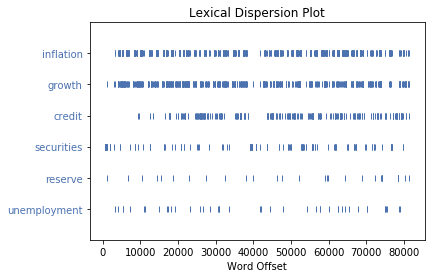

In [44]:
# Examine the words "inflation", "growth", "credit", "securities", "reserve", "unemployment"
sns.reset_orig() #Seaborn messes with this plot, disabling it
preText.dispersion_plot(['inflation', 'growth', 'credit', 'securities', 'reserve', 'unemployment'])
sns.set() #Re-enabling seaborn

In [45]:
# Turn post-crisis Minutes into an nltk object
postText = nltk.Text(postTokens)

# Examine the word "inflation"
postIndex = nltk.text.ConcordanceIndex(postText) 
postIndex.print_concordance('inflation')

Displaying 25 of 587 matches:
he decline in real activity On the inflation front headline consumer prices dec
n the third quarter consumer price inflation moderated in all advanced foreign 
er in the current quarter Headline inflation generally declined across emerging
t months while core consumer price inflation slowed further With energy prices 
ent slowing in core consumer price inflation was widespread and likely reflecte
hird consecutive month Measures of inflation expectations continued to fall or 
 for economic activity it expected inflation to moderate in coming quarters to 
ok for economic activity and lower inflation than had been anticipated along wi
ed policy path Meanwhile yields on inflation indexed Treasury securities declin
eclined by smaller amounts leaving inflation compensation lower Although the de
tion lower Although the decline in inflation compensation occurred amid sharp d
n occurred amid sharp decreases in inflation measures and energy prices it was 
ury securi

In [46]:
postText.common_contexts(['inflation'])

the_front price_moderated headline_generally price_slowed price_was
of_expectations expected_to lower_than on_indexed leaving_compensation
in_compensation in_measures of_protected lower_and in_expectations
pce_core core_was outcome_pressures that_could which_would


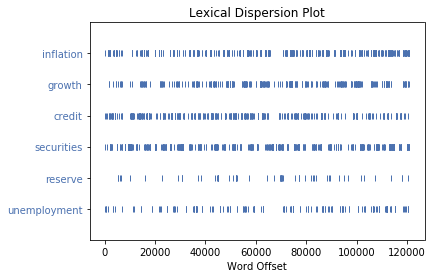

In [47]:
# Examine the words "inflation", "growth", "credit", "securities", "reserve", "unemployment"
sns.reset_orig() #Seaborn messes with this plot, disabling it
postText.dispersion_plot(['inflation', 'growth', 'credit', 'securities', 'reserve', 'unemployment'])
sns.set() #Re-enabling seaborn

### Summary
From frequency analysis, an interesting fact is that the frequencty of "inflation" and "growth" dropped after the crisis. On the contrary, "securities" and "reserve" become more frequent after the crisis. Moreover, pre-crisis text analysis shows that "inflation" is more likely to be higher than expectation, and to remain at the previous level. Post-crisis text analysis shows that "inflation" is more likely to be low, with price increasing slowly. The dispersion plot shows that before the crisis, inflation and growth are more likely to be mentioned, but after the crisis, credit, securities, and unemployment become more important.

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent than the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [48]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

What are we doing here? We want to get the list of all words in the corpus, and then count how many times each word is used. `whReleases['tokenized_text'].sum()` does the the former; and the rest of the codes in the loop does the latter. And then we use sorted function to sort the words in a descending order, i.e., arranged from the largest to the smallest number.

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [49]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

We're already familiar with for and if statements. But what does the break statement do here? Let's go back to what we are up to: We are trying to find words that occur more frequently than Whitehouse, which is the cutoff word that we're using here. So, using "break", we stopped when we see "Whitehouse"; then, we appended the words that appeared before "Whitehouse", i.e., the words that occurred more frequently than Whitehouse. As you can see, what the break statement does is: it stops the execution of the loop and move on to the next line of code. 

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [50]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [51]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...",raw/Whitehouse/10Mar2008Whitehouse8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sens, reed, whitehouse, welcome, rhode, islan...",198
6,10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,raw/Whitehouse/10Sep2007Whitehouse72.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,raw/Whitehouse/11Apr2007Whitehouse122.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...",raw/Whitehouse/11Jan2007Whitehouse161.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sens, reed, whitehouse, urge, portugal, recon...",237
9,11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,raw/Whitehouse/11Mar2008Whitehouse7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveil, bush, debt, $, foregone, ...",242


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [52]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


From this we can lookup the distributions of different word lengths

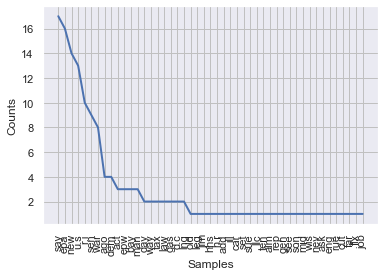

In [53]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [54]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [55]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [56]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [57]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 132, 'NNP': 34})),
 ('whitehouse', FreqDist({'NNP': 17, 'VB': 14, 'NN': 4, 'RB': 4, 'WDT': 1})),
 ('shares', FreqDist({'VBZ': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [58]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [59]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'potential': 5, 'fiscal': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [60]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('stem', 10),
 ('consulate', 10)]

Or plot the base form verbs against their number of occurrences

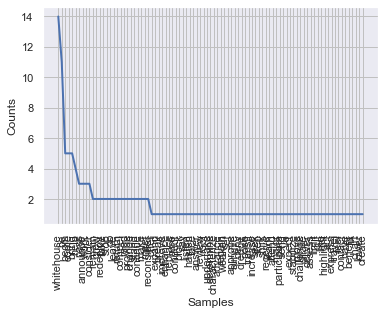

In [61]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [62]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

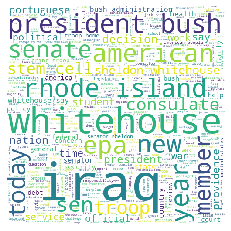

In [63]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [64]:
# Count the words for pre-crisis Minutes
pre_countsDict = {}
for word in preTokens:
    if word in pre_countsDict:
        pre_countsDict[word] += 1
    else:
        pre_countsDict[word] = 1
pre_word_counts = sorted(pre_countsDict.items(), key = lambda x : x[1], reverse = True)
pre_word_counts[:20]

[('the', 5161),
 ('in', 3186),
 ('of', 2748),
 ('and', 2436),
 ('to', 2259),
 ('that', 1142),
 ('a', 1061),
 ('for', 857),
 ('on', 818),
 ('inflation', 643),
 ('was', 566),
 ('had', 556),
 ('as', 533),
 ('The', 528),
 ('growth', 500),
 ('Committee', 461),
 ('with', 449),
 ('economic', 433),
 ('at', 432),
 ('were', 428)]

In [65]:
# Find the stop words. 
# To adjust for the high frequency of the word "inflation", I choose the second noun ("growth") as the cutoff
pre_stop_words_freq = []
for word, count in pre_word_counts:
    if word == 'inflation':
        continue
    elif word == 'growth':
        break
    else:
        pre_stop_words_freq.append(word)
pre_stop_words_freq

['the',
 'in',
 'of',
 'and',
 'to',
 'that',
 'a',
 'for',
 'on',
 'was',
 'had',
 'as',
 'The']

In [66]:
# Count the words for post-crisis Minutes
post_countsDict = {}
for word in postTokens:
    if word in post_countsDict:
        post_countsDict[word] += 1
    else:
        post_countsDict[word] = 1
post_word_counts = sorted(post_countsDict.items(), key = lambda x : x[1], reverse = True)
post_word_counts[:20]

[('the', 7702),
 ('of', 4464),
 ('in', 3976),
 ('and', 3725),
 ('to', 3386),
 ('that', 1679),
 ('a', 1431),
 ('for', 1271),
 ('on', 1119),
 ('The', 820),
 ('as', 795),
 ('was', 761),
 ('Committee', 715),
 ('were', 651),
 ('with', 643),
 ('by', 630),
 ('economic', 625),
 ('be', 612),
 ('inflation', 587),
 ('at', 580)]

In [67]:
# Find the stop words. I mimic the method described in the above sections and choose "Committee" as the cutoff.
post_stop_words_freq = []
for word, count in post_word_counts:
    if word == 'Committee':
        break
    else:
        post_stop_words_freq.append(word)
post_stop_words_freq

['the', 'of', 'in', 'and', 'to', 'that', 'a', 'for', 'on', 'The', 'as', 'was']

In [68]:
# Normalize the pre- and post- crisis Minutes
pre_norm = normalizeTokens(preTokens, pre_stop_words_freq)
post_norm = normalizeTokens(postTokens, post_stop_words_freq)

In [69]:
# Frequency distribution for pre- and post- crisis Minutes (conditional on word length)
precfdist = nltk.ConditionalFreqDist(((len(w), w) for w in preTokens))
postcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in postTokens))

In [70]:
# List the most common 9-letter words for pre-crisis Minutes
precfdist[9].most_common(20)

[('inflation', 643),
 ('Committee', 461),
 ('financial', 362),
 ('continued', 219),
 ('increased', 140),
 ('pressures', 122),
 ('increases', 104),
 ('suggested', 101),
 ('September', 100),
 ('liquidity', 93),
 ('generally', 88),
 ('economies', 82),
 ('statement', 77),
 ('indicated', 75),
 ('potential', 74),
 ('equipment', 69),
 ('stability', 62),
 ('mortgages', 62),
 ('following', 53),
 ('corporate', 52)]

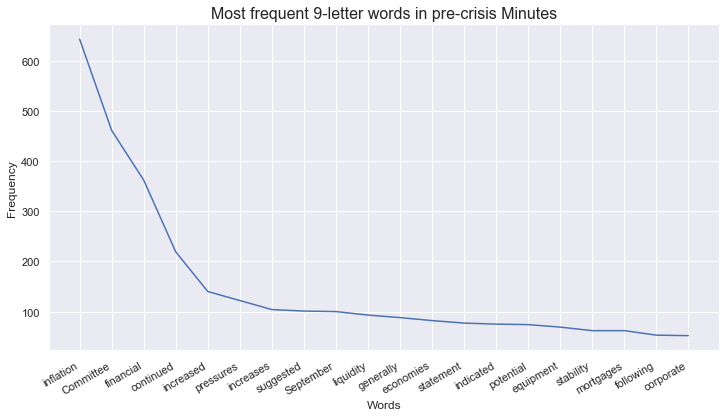

In [71]:
# Plot these words
pre_top20_words = list(map(lambda x: x[0], precfdist[9].most_common(20)))
pre_top20_wordsfq = list(map(lambda x: x[1], precfdist[9].most_common(20)))
ax = plt.figure(figsize=(12, 6)).gca()
ax.plot(pre_top20_words, pre_top20_wordsfq)
ax.set_xlabel("Words", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Most frequent 9-letter words in pre-crisis Minutes", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [72]:
# List the most common 9-letter words for post-crisis Minutes
postcfdist[9].most_common(20)

[('Committee', 715),
 ('inflation', 587),
 ('financial', 432),
 ('continued', 425),
 ('purchases', 241),
 ('increased', 191),
 ('generally', 147),
 ('stability', 140),
 ('suggested', 133),
 ('liquidity', 124),
 ('including', 105),
 ('equipment', 103),
 ('economies', 100),
 ('indicated', 98),
 ('increases', 94),
 ('household', 88),
 ('September', 87),
 ('following', 82),
 ('statement', 74),
 ('unchanged', 73)]

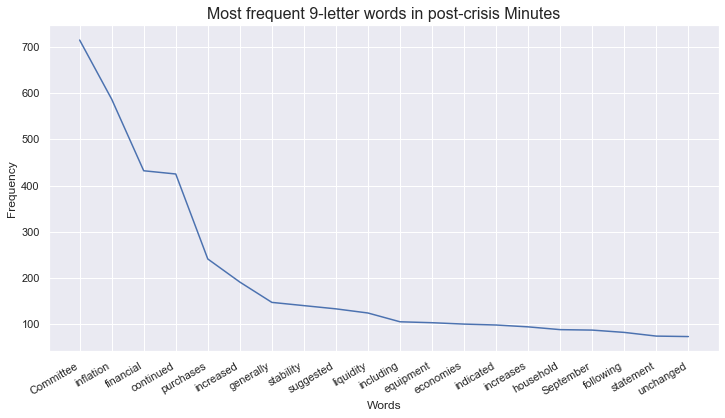

In [73]:
# Plot these words
post_top20_words = list(map(lambda x: x[0], postcfdist[9].most_common(20)))
post_top20_wordsfq = list(map(lambda x: x[1], postcfdist[9].most_common(20)))
ax = plt.figure(figsize=(12, 6)).gca()
ax.plot(post_top20_words, post_top20_wordsfq)
ax.set_xlabel("Words", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Most frequent 9-letter words in post-crisis Minutes", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [74]:
# Get the POS and the conditional frequency dist in normalized texts for both pre- and post- crisis Minutes
pre_pos = [spacy_pos(t) for t in pre_norm]
precfdist_POStoWord = nltk.ConditionalFreqDist((pos[0][1], pos[0][0]) for pos in pre_pos)

post_pos = [spacy_pos(t) for t in post_norm]
postcfdist_POStoWord = nltk.ConditionalFreqDist((pos[0][1], pos[0][0]) for pos in post_pos)

In [75]:
# List the most common "NN" for pre-crisis Minutes
precfdist_POStoWord['NN'].most_common(20)

[('market', 833),
 ('inflation', 657),
 ('price', 579),
 ('growth', 516),
 ('quarter', 486),
 ('rate', 467),
 ('increase', 401),
 ('participant', 397),
 ('decline', 307),
 ('meeting', 304),
 ('year', 301),
 ('bank', 276),
 ('risk', 262),
 ('policy', 257),
 ('condition', 254),
 ('credit', 252),
 ('consumer', 229),
 ('period', 220),
 ('activity', 220),
 ('month', 216)]

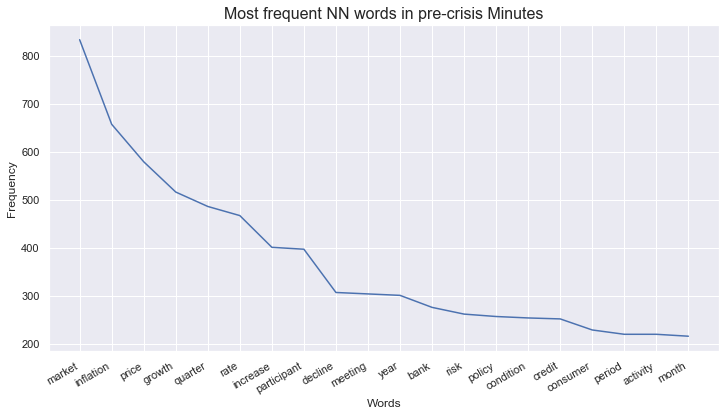

In [76]:
# Plot these words
pre_top20_NNwords = list(map(lambda x: x[0], precfdist_POStoWord['NN'].most_common(20)))
pre_top20_NNwordsfq = list(map(lambda x: x[1], precfdist_POStoWord['NN'].most_common(20)))
ax = plt.figure(figsize=(12, 6)).gca()
ax.plot(pre_top20_NNwords, pre_top20_NNwordsfq)
ax.set_xlabel("Words", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Most frequent NN words in pre-crisis Minutes", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [77]:
# List the most common "NN" for post-crisis Minutes
postcfdist_POStoWord['NN'].most_common(20)

[('market', 1057),
 ('rate', 767),
 ('price', 660),
 ('inflation', 603),
 ('participant', 574),
 ('increase', 569),
 ('security', 518),
 ('decline', 507),
 ('bank', 506),
 ('term', 462),
 ('condition', 437),
 ('year', 432),
 ('period', 427),
 ('quarter', 427),
 ('level', 415),
 ('credit', 414),
 ('purchase', 411),
 ('consumer', 339),
 ('policy', 332),
 ('month', 320)]

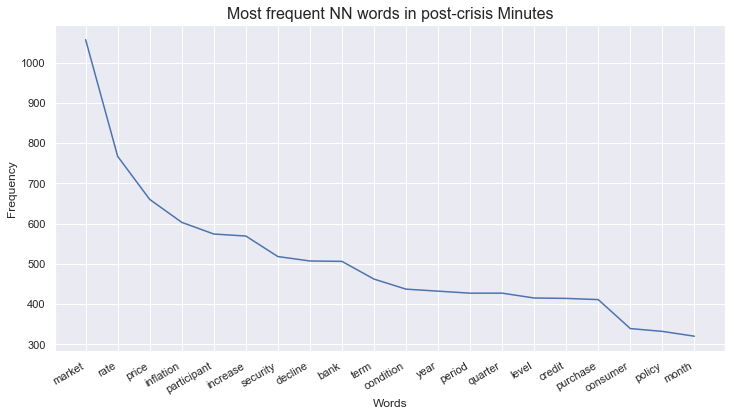

In [78]:
# Plot these words
post_top20_NNwords = list(map(lambda x: x[0], postcfdist_POStoWord['NN'].most_common(20)))
post_top20_NNwordsfq = list(map(lambda x: x[1], postcfdist_POStoWord['NN'].most_common(20)))
ax = plt.figure(figsize=(12, 6)).gca()
ax.plot(post_top20_NNwords, post_top20_NNwordsfq)
ax.set_xlabel("Words", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Most frequent NN words in post-crisis Minutes", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

(-0.5, 499.5, 499.5, -0.5)

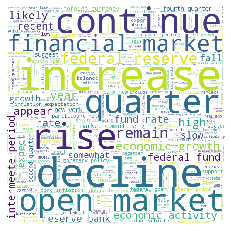

In [79]:
# Generate a word cloud for pre-crisis Minutes
pre_wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, 
                             mode ='RGBA', scale=.5).generate(' '.join(pre_norm))
plt.imshow(pre_wc)
plt.axis("off")

(-0.5, 499.5, 499.5, -0.5)

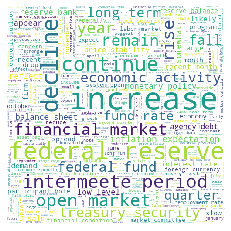

In [80]:
# Generate a word cloud for post-crisis Minutes
post_wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, 
                              mode ='RGBA', scale=.5).generate(' '.join(post_norm))
plt.imshow(post_wc)
plt.axis("off")

### Summary
From the above analysis, we can see that the central bankers focus more on stimulating the economy instead of controling the inflation and promoting the growth after the crisis. To be specific, before crisis, "rise" appears more frequently, which may indicate the rise of federal funds rate to control the inflation; "growth" is also more likely to be used. After the crisis, "security", "treasury", and "reserve" become frequent used words, indicating the central bankers are trying their best to utilize different monetary policies to provide extra liquidity to the market.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [81]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [82]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [83]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [84]:
movie_texts = {}

In [85]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [86]:
import pandas as pd

In [87]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [88]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [89]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French","[Louis, Louis, Beretti, Shh, Put, that, out, y..."
6880640,Dishonored,"Drama, Romance, War",1931,English,"[I, thought, I, smelled, gas, That, 's, three,..."
5482259,Indiscreet,"Comedy, Drama, Musical",1931,English,"[Subtitles, Lu, s, Filipe, Bernardes, Wait, Yo..."
5192597,The Stolen Jools,"Comedy, Short",1931,English,"[Subtitles, Lu, s, Filipe, Bernardes, Hello, W..."
3982760,College Humor,Comedy,1933,English,"[Play, ball, Although, the, game, seems, uphil..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [90]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [91]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [92]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [93]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [94]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours], [..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>], [$, Me], [Hello, IT], [>, $], [Usr, Hi, ..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [95]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [96]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [97]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, NNP), (Post](https://www.reddit.c...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, CD), ...
1    [[(>, XX)], [($, $)], [(Me, PRP)], [(Hello, UH...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [98]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('m', 21),
 ('password', 21),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('Genius', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7),
 ('job', 7)]

What about the adjectives that modify the word, "computer"?

In [99]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

Since it takes me quite a long time to run the cells for Exercise 2, I decide to choose the Minutes on Jan. 31, 2007, Mar. 21, 2007, and May 9, 2007 as the pre-crisis sample and to choose the Minutes on Jan. 28, 2009, Mar. 18, 2009, and Apr. 30, 2009 as the post-crisis sample.

In [100]:
# Write a funtion to select the Minutes, clean the texts, and convert them into a dataframe
def load_corpus_to_df(corpus_name, df):
    if corpus_name == Minutes_pre_txt:
        for file in os.listdir(corpus_name + "/"):
            if file in ['text_20070131.txt', 'text_20070321.txt', 'text_20070509.txt']:
                with open(corpus_name + '/' + file, encoding="utf8", errors='ignore') as f:
                    for line in f:
                        line_clean = line.replace('\n', '').replace('\t', ' ')
                        if line_clean:
                            df = df.append({'text': line_clean}, ignore_index=True)
    else:
        for file in os.listdir(corpus_name + "/"):
            if file in ['text_20090128.txt', 'text_20090318.txt', 'text_20090430.txt']:
                with open(corpus_name + '/' + file, encoding="utf8", errors='ignore') as f:
                    for line in f:
                        line_clean = line.replace('\n', '').replace('\t', ' ')
                        if line_clean:
                            df = df.append({'text': line_clean}, ignore_index=True)
    return df

In [101]:
# Construct the dataframe for pre- and post- crisis Minutes
pre_df = pandas.DataFrame(columns = ["text"])
pre_df = load_corpus_to_df(Minutes_pre_txt, pre_df)

post_df = pandas.DataFrame(columns = ["text"])
post_df = load_corpus_to_df(Minutes_post_txt, post_df)

In [102]:
# Tokenize the sentences and add POS tagging
pre_df['sentences'] = pre_df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
pre_df['POS_sents'] = pre_df['sentences'].apply(lambda x: tag_sents_pos(x))

post_df['sentences'] = post_df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
post_df['POS_sents'] = post_df['sentences'].apply(lambda x: tag_sents_pos(x))

In [103]:
pre_df.head()

,text,sentences,POS_sents
0,"In the agenda for this meeting, it was reporte...","[[In, the, agenda, for, this, meeting, it, was...","[[(In, IN), (the, DT), (agenda, NN), (for, IN)..."
1,The elected members and alternate members were...,"[[The, elected, members, and, alternate, membe...","[[(The, DT), (elected, VBN), (members, NNS), (..."
2,"Timothy F. Geithner, President of the Federal ...","[[Timothy, F., Geithner, President, of, the, F...","[[(Timothy, NNP), (F., NNP), (Geithner, NNP), ..."
3,"Cathy E. Minehan, President of the Federal Res...","[[Cathy, E., Minehan, President, of, the, Fede...","[[(Cathy, NNP), (E., NNP), (Minehan, NNP), (Pr..."
4,"Michael H. Moskow, President of the Federal Re...","[[Michael, H., Moskow, President, of, the, Fed...","[[(Michael, NNP), (H., NNP), (Moskow, NNP), (P..."


In [104]:
post_df.head()

,text,sentences,POS_sents
0,"In the agenda for this meeting, it was reporte...","[[In, the, agenda, for, this, meeting, it, was...","[[(In, IN), (the, DT), (agenda, NN), (for, IN)..."
1,The elected members and alternate members were...,"[[The, elected, members, and, alternate, membe...","[[(The, DT), (elected, VBN), (members, NNS), (..."
2,"William C. Dudley, President of the Federal Re...","[[William, C., Dudley, President, of, the, Fed...","[[(William, NNP), (C., NNP), (Dudley, NNP), (P..."
3,"Jeffrey M. Lacker, President of the Federal Re...","[[Jeffrey, M., Lacker, President, of, the, Fed...","[[(Jeffrey, NNP), (M., NNP), (Lacker, NNP), (P..."
4,"Charles L. Evans, President of the Federal Res...","[[Charles, L., Evans, President, of, the, Fede...","[[(Charles, NNP), (L., NNP), (Evans, NNP), (Pr..."


In [105]:
# Count the most common nouns in pre-crisis sample
countTarget = 'NN'
pre_targetCounts_NN = {}
for entry in pre_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in pre_targetCounts_NN:
                pre_targetCounts_NN[ent] += 1
            else:
                pre_targetCounts_NN[ent] = 1

pre_sortedTargets_NN = sorted(pre_targetCounts_NN.items(), key = lambda x: x[1], reverse = True)
pre_sortedTargets_NN[:20]

[('inflation', 121),
 ('growth', 89),
 ('quarter', 63),
 ('year', 61),
 ('meeting', 50),
 ('market', 49),
 ('pace', 49),
 ('rate', 45),
 ('spending', 45),
 ('policy', 36),
 ('activity', 36),
 ('investment', 34),
 ('housing', 32),
 ('consumer', 31),
 ('percent', 30),
 ('energy', 30),
 ('period', 29),
 ('core', 28),
 ('sector', 28),
 ('price', 27)]

In [106]:
# Count the most common nouns in post-crisis sample
post_targetCounts_NN = {}
for entry in post_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in post_targetCounts_NN:
                post_targetCounts_NN[ent] += 1
            else:
                post_targetCounts_NN[ent] = 1

post_sortedTargets_NN = sorted(post_targetCounts_NN.items(), key = lambda x: x[1], reverse = True)
post_sortedTargets_NN[:20]

[('market', 74),
 ('credit', 65),
 ('period', 57),
 ('inflation', 56),
 ('term', 50),
 ('year', 43),
 ('balance', 41),
 ('meeting', 40),
 ('rate', 38),
 ('quarter', 36),
 ('consumer', 34),
 ('currency', 33),
 ('debt', 33),
 ('time', 31),
 ('agency', 31),
 ('spending', 31),
 ('price', 30),
 ('activity', 30),
 ('mortgage', 29),
 ('sheet', 29)]

### Summary for NN
As confirmed by previous analysis, "inflation" and "growth" are more likely to appear in pre-crisis Minutes, so the central bankers are focusing on how to control inflation and promote growth. After the crisis, "term", "balance", "mortgage", "sheet" become more frequent, suggesting the central bankers are trying their best to make their monetary policies work.

In [107]:
# Count the most common verbs in pre-crisis sample
countTarget = 'VB'
pre_targetCounts_VB = {}
for entry in pre_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in pre_targetCounts_VB:
                pre_targetCounts_VB[ent] += 1
            else:
                pre_targetCounts_VB[ent] = 1

pre_sortedTargets_VB = sorted(pre_targetCounts_VB.items(), key = lambda x: x[1], reverse = True)
pre_sortedTargets_VB[:20]

[('be', 72),
 ('have', 35),
 ('moderate', 17),
 ('fail', 11),
 ('expand', 10),
 ('depend', 8),
 ('continue', 7),
 ('foster', 7),
 ('remain', 6),
 ('rise', 6),
 ('pick', 6),
 ('expect', 6),
 ('provide', 5),
 ('sustain', 5),
 ('edge', 5),
 ('execute', 4),
 ('sell', 4),
 ('maintain', 4),
 ('offset', 4),
 ('advance', 4)]

In [108]:
# Count the most common verbs in post-crisis sample
post_targetCounts_VB = {}
for entry in post_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in post_targetCounts_VB:
                post_targetCounts_VB[ent] += 1
            else:
                post_targetCounts_VB[ent] = 1

post_sortedTargets_VB = sorted(post_targetCounts_VB.items(), key = lambda x: x[1], reverse = True)
post_sortedTargets_VB[:20]

[('be', 84),
 ('purchase', 20),
 ('have', 18),
 ('provide', 15),
 ('increase', 13),
 ('support', 13),
 ('expand', 13),
 ('remain', 9),
 ('decline', 9),
 ('help', 8),
 ('continue', 8),
 ('maintain', 7),
 ('keep', 7),
 ('stabilize', 7),
 ('ensure', 6),
 ('facilitate', 6),
 ('improve', 6),
 ('contract', 6),
 ('fall', 6),
 ('take', 5)]

### Summary for VB
"foster" is frequently used in pre-crisis Minutes, implying that the economic growth is satisfying. On the other hand, "sell" and "offset" may indicate the central bankers' effort to control inflation. However, after the crisis, "support" becomes more common, which suggests that the economy is not well-functioning. Moreover, "purchase" demonstrates that the central bankers are trying to provide extra liquidity to the market.

In [109]:
# Count the most common adjectives in pre-crisis sample
countTarget = 'JJ'
pre_targetCounts_JJ = {}
for entry in pre_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in pre_targetCounts_JJ:
                pre_targetCounts_JJ[ent] += 1
            else:
                pre_targetCounts_JJ[ent] = 1

pre_sortedTargets_JJ = sorted(pre_targetCounts_JJ.items(), key = lambda x: x[1], reverse = True)
pre_sortedTargets_JJ[:20]

[('economic', 65),
 ('recent', 60),
 ('foreign', 55),
 ('first', 33),
 ('likely', 29),
 ('such', 28),
 ('high', 27),
 ('other', 26),
 ('fourth', 26),
 ('last', 22),
 ('federal', 20),
 ('monetary', 18),
 ('moderate', 17),
 ('core', 17),
 ('new', 16),
 ('previous', 16),
 ('domestic', 15),
 ('elevated', 15),
 ('open', 14),
 ('financial', 13)]

In [110]:
# Count the most common adjectives in post-crisis sample
post_targetCounts_JJ = {}
for entry in post_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in post_targetCounts_JJ:
                post_targetCounts_JJ[ent] += 1
            else:
                post_targetCounts_JJ[ent] = 1

post_sortedTargets_JJ = sorted(post_targetCounts_JJ.items(), key = lambda x: x[1], reverse = True)
post_sortedTargets_JJ[:20]

[('financial', 74),
 ('economic', 71),
 ('foreign', 67),
 ('such', 42),
 ('other', 40),
 ('low', 28),
 ('monetary', 26),
 ('fourth', 25),
 ('recent', 24),
 ('high', 22),
 ('additional', 21),
 ('federal', 21),
 ('real', 20),
 ('commercial', 19),
 ('likely', 18),
 ('first', 17),
 ('open', 17),
 ('weak', 17),
 ('large', 16),
 ('new', 15)]

### Summary for JJ
Adjectives do not show such an obvious pattern as nouns and verbs. The increasing frequency of "monetary" and "additional" may suggest that the central bankers are enacting more intense monetary policies after the crisis. In addition, "commercial" becomes more common after the crisis, which may imply the process of quantitative easing.

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [111]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [112]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [113]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  9, The second word is: 40
The first word is:  40, The second word is: 4
The first word is:  4, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 12
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 9
The first word is:  9, The second word is: 4


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [114]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

There are a few other available measures

In [115]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [116]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [117]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [118]:
import gensim

In [119]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [120]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [121]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In this exercise I use the same sample as in Exercise 1 and 2 because I have normalized them before.

In [122]:
# Examine the bigrams in pre-crisis sample
preBigrams = nltk.collocations.BigramCollocationFinder.from_words(pre_norm)
print("There are {} bigrams in the finder".format(preBigrams.N))
print(preBigrams.nbest(bigramScoring, 10))

pre_bigramScores = []

def bigramPrinting(count, wordsTuple, total):
    global pre_bigramScores
    pre_bigramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

preBigrams.nbest(bigramPrinting, 10)
print('\n'.join(pre_bigramScores[:10]))

There are 46841 bigrams in the finder
[('open', 'market'), ('financial', 'market'), ('federal', 'reserve'), ('economic', 'growth'), ('economic', 'activity'), ('fund', 'rate'), ('intermeete', 'period'), ('federal', 'fund'), ('reserve', 'bank'), ('foreign', 'currency')]
The first word is:  4, The second word is: 304
The first word is:  304, The second word is: 126
The first word is:  126, The second word is: 5
The first word is:  5, The second word is: 4
The first word is:  4, The second word is: 66
The first word is:  66, The second word is: 131
The first word is:  131, The second word is: 22
The first word is:  22, The second word is: 131
The first word is:  131, The second word is: 411
The first word is:  411, The second word is: 194


In [123]:
# Check the likelihood ratio of bigrams in pre-crisis sample
bigram_measures = nltk.collocations.BigramAssocMeasures()
preBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[(('federal', 'reserve'), 1513.2288081725342),
 (('open', 'market'), 1447.642376616558),
 (('intermeete', 'period'), 1442.7416305401453),
 (('motor', 'vehicle'), 1091.614674159227),
 (('new', 'york'), 1002.9757258477794),
 (('fund', 'rate'), 993.3423324829857),
 (('financial', 'market'), 985.2802458528938),
 (('federal', 'fund'), 972.4071073025107),
 (('economic', 'activity'), 963.4196793505799),
 (('reserve', 'bank'), 937.9277777730657),
 (('economic', 'growth'), 903.0751936281704),
 (('downside', 'risk'), 841.0155310479407),
 (('foreign', 'currency'), 834.3562032362124),
 (('fourth', 'quarter'), 803.9959531866732),
 (('monetary', 'policy'), 753.4532970428022),
 (('bank', 'new'), 653.3820865051196),
 (('second', 'quarter'), 651.6747526892002),
 (('participant', 'note'), 577.2121303292097),
 (('united', 'states'), 551.2248027228777),
 (('federal', 'open'), 550.0577430245178),
 (('inflation', 'expectation'), 548.6305481085542),
 (('system', 'open'), 542.087853642685),
 (('basis', 'point

In [124]:
# Examine the bigrams in post-crisis sample
postBigrams = nltk.collocations.BigramCollocationFinder.from_words(post_norm)
print("There are {} bigrams in the finder".format(postBigrams.N))
print(postBigrams.nbest(bigramScoring, 10))

post_bigramScores = []

def bigramPrinting(count, wordsTuple, total):
    global post_bigramScores
    post_bigramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

postBigrams.nbest(bigramPrinting, 10)
print('\n'.join(post_bigramScores[:10]))

There are 69758 bigrams in the finder
[('federal', 'reserve'), ('intermeete', 'period'), ('open', 'market'), ('financial', 'market'), ('treasury', 'security'), ('federal', 'fund'), ('economic', 'activity'), ('long', 'term'), ('fund', 'rate'), ('inflation', 'expectation')]
The first word is:  110, The second word is: 242
The first word is:  242, The second word is: 227
The first word is:  227, The second word is: 1057
The first word is:  1057, The second word is: 154
The first word is:  154, The second word is: 158
The first word is:  158, The second word is: 314
The first word is:  314, The second word is: 123
The first word is:  123, The second word is: 265
The first word is:  265, The second word is: 34
The first word is:  34, The second word is: 1057


In [125]:
# Check the likelihood ratio of bigrams in post-crisis sample
bigram_measures = nltk.collocations.BigramAssocMeasures()
postBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[(('federal', 'reserve'), 3819.234435761917),
 (('intermeete', 'period'), 2698.4646651949743),
 (('open', 'market'), 1814.1864972277867),
 (('balance', 'sheet'), 1496.6757603043027),
 (('treasury', 'security'), 1390.3521538490331),
 (('long', 'term'), 1358.3687213317992),
 (('federal', 'fund'), 1342.1805624668434),
 (('economic', 'activity'), 1262.5203323723088),
 (('inflation', 'expectation'), 1140.2340932835884),
 (('fund', 'rate'), 1083.361064801143),
 (('monetary', 'policy'), 1062.0860409088805),
 (('motor', 'vehicle'), 1009.7666636138251),
 (('agency', 'debt'), 995.3824565150295),
 (('price', 'stability'), 962.0625385729666),
 (('new', 'york'), 954.8179592453836),
 (('interest', 'rate'), 929.7088182966904),
 (('financial', 'market'), 905.6375414073381),
 (('foreign', 'currency'), 855.6425167457621),
 (('fourth', 'quarter'), 852.2920422021319),
 (('recent', 'month'), 842.8100852256954),
 (('real', 'estate'), 788.7805255008318),
 (('low', 'level'), 772.0655179046381),
 (('commercial

### Summary for bigrams
No matter which sample we use, most bigrams are jargons in economics. However, we may notice that bigrams like "balance sheet", "treasury security", and "bank security" are observed in the post-crisis sample, while "economic activity", "economic growth", and "core inflation" are observed in the pre-crisis sample. The difference suggests the changes in economic perspectives.

In [126]:
# Check 3-gram phrases by student-t values for pre-crisis sample
trigram_measures = nltk.collocations.TrigramAssocMeasures()
preTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(pre_norm)
preTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('federal', 'fund', 'rate'), 10.861338978697827),
 (('federal', 'reserve', 'bank'), 10.24573480122242),
 (('federal', 'open', 'market'), 9.161848481022481),
 (('reserve', 'bank', 'new'), 9.10988784816218),
 (('open', 'market', 'committee'), 9.051635508146365),
 (('bank', 'new', 'york'), 8.944078163034952),
 (('system', 'open', 'market'), 8.122660351273339),
 (('target', 'federal', 'fund'), 7.809880463683597),
 (('open', 'market', 'account'), 7.140159858537921),
 (('downside', 'risk', 'growth'), 6.6324414314296245),
 (('open', 'market', 'operation'), 6.2440190941713585),
 (('direct', 'federal', 'reserve'), 5.9996463666984505),
 (('upside', 'risk', 'inflation'), 5.830346432136192),
 (('period', 'previous', 'meeting'), 5.291053298213324),
 (('tight', 'credit', 'condition'), 5.195770646400458),
 (('reading', 'core', 'inflation'), 5.195312211064103),
 (('expand', 'moderate', 'pace'), 5.098754673775002),
 (('rate', 'basis', 'point'), 5.0986615303790055),
 (('advanced', 'foreign', 'economy'

In [127]:
# Check 3-gram phrases by student-t values for post-crisis sample
trigram_measures = nltk.collocations.TrigramAssocMeasures()
postTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(post_norm)
postTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('federal', 'fund', 'rate'), 12.285927261721055),
 (('federal', 'reserve', 'bank'), 10.719942270511918),
 (('system', 'open', 'market'), 9.27233179062906),
 (('federal', 'open', 'market'), 9.051404769881783),
 (('reserve', 'bank', 'new'), 8.942877993800135),
 (('open', 'market', 'committee'), 8.94033029818006),
 (('bank', 'new', 'york'), 8.831553648154022),
 (('federal', 'reserve', 'balance'), 8.599850790586133),
 (('open', 'market', 'account'), 8.245290422066825),
 (('mortgage', 'back', 'security'), 8.061846779970777),
 (('reserve', 'balance', 'sheet'), 7.680656706595421),
 (('commercial', 'real', 'estate'), 7.348364403582827),
 (('long', 'term', 'treasury'), 7.27907572582536),
 (('open', 'market', 'operation'), 7.140599897163667),
 (('term', 'treasury', 'security'), 7.068946529257886),
 (('consumer', 'price', 'inflation'), 6.851610480942743),
 (('maximum', 'employment', 'price'), 6.782123368349663),
 (('employment', 'price', 'stability'), 6.781870839179479),
 (('target', 'range', '

### Summary for trigrams
The trigrams from two samples are becoming more similar to each other, most of which are again economic jargons. However, clues of different economic perspectives could also be found, such as "downside risk growth" vs. "federal reserve balance". 

In [128]:
# Check 4-gram phrases for pre-crisis

preNgrams = nltk.ngrams(pre_norm, 4)
Counts = {}
for ngram in list(preNgrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 3:
        pass
    else:
        Filtered[key] = Counts[key]

# Find the most common 4-grams 

sorted(Filtered.items(), key=lambda x: x[1])[-20:]

[(('percent', 'vote', 'encompass', 'approval'), 17),
 (('vote', 'action', 'messrs', 'bernanke'), 17),
 (('action', 'messrs', 'bernanke', 'geithner'), 17),
 (('inflation', 'fail', 'moderate', 'expect'), 17),
 (('promote', 'moderate', 'growth', 'time'), 17),
 (('downside', 'risk', 'growth', 'remain'), 17),
 (('risk', 'inflation', 'fail', 'moderate'), 18),
 (('conclusion', 'discussion', 'committee', 'vote'), 18),
 (('foreign', 'exchange', 'value', 'dollar'), 20),
 (('manager', 'system', 'open', 'market'), 21),
 (('federal', 'fund', 'rate', 'basis'), 21),
 (('president', 'federal', 'reserve', 'bank'), 22),
 (('fund', 'rate', 'basis', 'point'), 22),
 (('authorize', 'direct', 'federal', 'reserve'), 25),
 (('direct', 'federal', 'reserve', 'bank'), 36),
 (('system', 'open', 'market', 'account'), 51),
 (('target', 'federal', 'fund', 'rate'), 61),
 (('reserve', 'bank', 'new', 'york'), 80),
 (('federal', 'open', 'market', 'committee'), 82),
 (('federal', 'reserve', 'bank', 'new'), 82)]

In [129]:
# Check 4-gram phrases for post-crisis

postNgrams = nltk.ngrams(post_norm, 4)
Counts = {}
for ngram in list(postNgrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 3:
        pass
    else:
        Filtered[key] = Counts[key]

# Find the most common 4-grams 

sorted(Filtered.items(), key=lambda x: x[1])[-20:]

[(('direct', 'federal', 'reserve', 'bank'), 28),
 (('federal', 'fund', 'rate', 'extended'), 29),
 (('fund', 'rate', 'extended', 'period'), 29),
 (('agency', 'mortgage', 'back', 'security'), 32),
 (('warrant', 'exceptionally', 'low', 'level'), 32),
 (('exceptionally', 'low', 'level', 'federal'), 32),
 (('size', 'federal', 'reserve', 'balance'), 33),
 (('low', 'level', 'federal', 'fund'), 34),
 (('likely', 'warrant', 'exceptionally', 'low'), 35),
 (('level', 'federal', 'fund', 'rate'), 38),
 (('long', 'term', 'inflation', 'expectation'), 38),
 (('target', 'range', 'federal', 'fund'), 45),
 (('range', 'federal', 'fund', 'rate'), 45),
 (('maximum', 'employment', 'price', 'stability'), 46),
 (('long', 'term', 'treasury', 'security'), 49),
 (('federal', 'reserve', 'balance', 'sheet'), 59),
 (('system', 'open', 'market', 'account'), 68),
 (('reserve', 'bank', 'new', 'york'), 78),
 (('federal', 'open', 'market', 'committee'), 80),
 (('federal', 'reserve', 'bank', 'new'), 80)]

### Summary for 4-grams
The implication is exactly the same as the ones from trigrams.

In [130]:
# Check whether "downside risk" and "balance sheet" are idiomatic and irreducible in both samples
# Find the highest-t_value bigrams begin with "downside" in pre-crisis 
i = 0
for grams in preBigrams.score_ngrams(bigram_measures.student_t):
    if 'downside' == grams[0][0]:
        print(grams)
        i += 1
    if i >= 10:
        break

(('downside', 'risk'), 9.001646400592316)
(('downside', 'turmoil'), 0.9591383616916803)
(('downside', 'reduction'), 0.9257061121666916)
(('downside', 'participant'), 0.8928164718882171)
(('downside', 'condition'), 0.5282338122584915)


In [131]:
# Find the highest-t_value bigrams begin with "downside" in post-crisis 
i = 0
for grams in postBigrams.score_ngrams(bigram_measures.student_t):
    if 'downside' == grams[0][0]:
        print(grams)
        i += 1
    if i >= 10:
        break

(('downside', 'risk'), 5.3656284373004866)
(('downside', 'near'), 1.3626792455126286)
(('downside', 'tail'), 0.9994122537916799)
(('downside', 'similarly'), 0.9976490151667192)
(('downside', 'nonetheless'), 0.9770778978755125)
(('downside', 'uncertainty'), 0.9735514206255913)
(('downside', 'particularly'), 0.9723759282089509)
(('downside', 'light'), 0.9559190343759856)
(('downside', 'housing'), 0.899495398377247)
(('downside', 'reflect'), 0.8936179362940451)


In [132]:
# Find the highest-t_value bigrams begin with "balance" in pre-crisis 
i = 0
for grams in preBigrams.score_ngrams(bigram_measures.student_t):
    if 'balance' == grams[0][0]:
        print(grams)
        i += 1
    if i >= 10:
        break

(('balance', 'sheet'), 4.988676586750923)
(('balance', 'intermeete'), 2.1133637412673125)
(('balance', 'risk'), 1.9809210735878133)
(('balance', 'downside'), 1.9052752930125318)
(('balance', 'participant'), 1.5677504750112081)
(('balance', 'gross'), 1.3957361878470957)
(('balance', 'outstanding'), 1.3741792509000965)
(('balance', 'week'), 1.3726394696895965)
(('balance', 'light'), 1.3387642830585977)
(('balance', 'authorize'), 1.3110482212695989)


In [133]:
# Find the highest-t_value bigrams begin with "downside" in post-crisis 
i = 0
for grams in postBigrams.score_ngrams(bigram_measures.student_t):
    if 'balance' == grams[0][0]:
        print(grams)
        i += 1
    if i >= 10:
        break

(('balance', 'sheet'), 11.271210933399098)
(('balance', 'sheetthe'), 3.8585480746971395)
(('balance', 'intermeete'), 3.4936214224198836)
(('balance', 'hold'), 1.7521431233693627)
(('balance', 'currency'), 1.686917629519195)
(('balance', 'see'), 1.3963570245141566)
(('balance', 'approximately'), 1.395765006770017)
(('balance', 'take'), 1.3219707843577049)
(('balance', 'outstanding'), 1.2982512128680332)
(('balance', 'raise'), 1.2745316413783614)


### Summary for idiomatic and irreducable collocations
Since "downside risk" and "balance sheet" have a higher t-stat in both samples, they should be idiomatic and irreducable. However, the t-stat of "downside risk" is much higher in pre-crisis sample while the t-stat of "balance sheet" is much higher in post-crisis sample.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [134]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [135]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [136]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [137]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [138]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [139]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Desk, PERSON)], [], [], ...
8    [[(Social, ORG)], [], [(today, DATE)], [(Citri...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [(offa, CARDINAL), (30,00...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [], [(Engineer, PERSON)], [(All good 10 m...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [], [], [], [(4, CARDINAL)], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[], [], [(the morning, TIME)], [(recently pas...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [140]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 9),
 ('today', 6),
 ('Boss', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

Or those occurring only twice:

In [141]:
[x[0] for x in sortedEntities if x[1] == 2]

['two',
 'first',
 '1',
 '3',
 '5',
 '10',
 'second',
 'each day',
 'Edit 2',
 '30k',
 'Caller',
 'XYZ',
 'last week',
 'three',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [142]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 7),
 ('today', 6),
 ('Boss', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

What about the Organizations?

In [143]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Social
Computer C O M P
Genius  
Genius
Genius
WeltallPrime
Fair
PMs
POS
COM
CMD
Google Chrome
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
/r
Proceed
Freedom


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In this exercise I use the same sample as in Exercise 3. But since it is not necessary to do any comparisons, I only use the post-crisis sample.

In [144]:
# Tag the post-crisis sample
post_df['classified_sents'] = post_df['sentences'].apply(lambda x: tag_sents_ner(x))
post_df['classified_sents']

0      [[(the Federal Open Market Committee, ORG), (J...
1                                                   [[]]
2      [[(William C. Dudley, PERSON), (the Federal Re...
3      [[(Jeffrey M. Lacker, PERSON), (the Federal Re...
4      [[(Charles L. Evans, PERSON), (the Federal Res...
                             ...                        
224    [[(Committee, ORG), (Tuesday Wednesday April 2...
225                                                 [[]]
226    [[(February 7 2009, DATE), (Committee, ORG), (...
227                                                 [[]]
228    [[(February 17 2009, DATE), (Committee, ORG), ...
Name: classified_sents, Length: 229, dtype: object

In [145]:
# Count the entities and list ten most common entities
entityCounts = {}
for entry in post_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Committee', 76),
 ('Treasury', 52),
 ("the Federal Reserve 's", 28),
 ('January', 28),
 ('the Federal Reserve Bank', 27),
 ('February', 27),
 ('System', 24),
 ('December', 20),
 ('the Federal Reserve', 19),
 ('U.S.', 18)]

In [146]:
# List all the types of entities
entityTypes = []
for entry in post_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind in entityTypes:
                continue
            else:
                entityTypes.append(kind)
entityTypes

['ORG',
 'DATE',
 'PERSON',
 'ORDINAL',
 'GPE',
 'LAW',
 'CARDINAL',
 'NORP',
 'MONEY',
 'PRODUCT',
 'WORK_OF_ART',
 'PERCENT',
 'TIME',
 'LOC',
 'EVENT']

In [147]:
# Count the frequency of each type of entities
entityFreq = {}
for entry in post_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind in entityFreq:
                entityFreq[kind] += 1
            else:
                entityFreq[kind] = 1
sortedTypes = sorted(entityFreq.items(), key = lambda x: x[1], reverse = True)
sortedTypes

[('ORG', 427),
 ('DATE', 328),
 ('PERSON', 73),
 ('GPE', 46),
 ('CARDINAL', 39),
 ('MONEY', 33),
 ('NORP', 19),
 ('LAW', 12),
 ('PERCENT', 11),
 ('TIME', 11),
 ('LOC', 8),
 ('ORDINAL', 7),
 ('PRODUCT', 7),
 ('WORK_OF_ART', 2),
 ('EVENT', 1)]

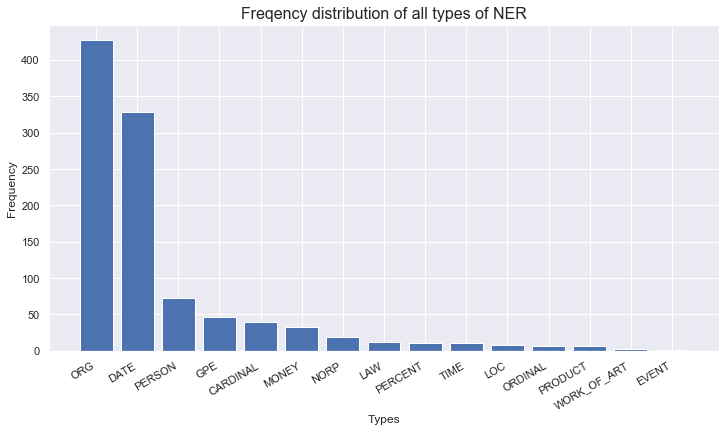

In [148]:
# Plot the frequency distribution
TypesName = list(map(lambda x: x[0], sortedTypes))
TypesFreq = list(map(lambda x: x[1], sortedTypes))
ax = plt.figure(figsize=(12, 6)).gca()
ax.bar(TypesName, TypesFreq)
ax.set_xlabel("Types", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Freqency distribution of all types of NER", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### Summary for frequency distribution
The most frequent types of NER in the post-crisis sample are "ORG" and "DATE", which is reasonable because FOMC Minutes have to emphasize the decisions made by different organizations to make their statement clear. Moreover, it also needs to precisely point out the time line of their actions so that the market will react as expected. 

In [149]:
# Calculate the classification table for "GPE"
GPEName=[]
for entry in post_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE' :
                GPEName.append(ent)
print(GPEName)

['Cleveland', 'Atlanta', 'St. Louis', 'San Francisco', 'New York', 'New Zealand', 'Singapore', 'New York', 'New York', 'U.S.', 'the United States', 'the United States', 'the United States', 'New York', 'New York', 'United States', 'New York Bank', 'U.S.', 'New York', 'U.S.', 'Japan', 'Canada', 'China', 'the United States', 'London', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'New York', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'Japan', 'the United States', 'Hourly', 'London', 'U.S.', 'U.S.', 'New York', 'U.S.']


In [150]:
True_GPE_indicator = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Pred_GPE_indicator = np.ones(46)

print(sklearn.metrics.classification_report(True_GPE_indicator, Pred_GPE_indicator))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.98      1.00      0.99        45

    accuracy                           0.98        46
   macro avg       0.49      0.50      0.49        46
weighted avg       0.96      0.98      0.97        46



C:\Users\Thinkpad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [151]:
from spacy import displacy

In [152]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [153]:
displacy.render(doc, style='dep')

In [154]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [155]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [156]:
from spacy.symbols import nsubj, VERB

In [157]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [158]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [159]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [160]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [161]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [162]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [163]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [164]:
movie_violences = {}

In [165]:
for index, row in movie_df[:10].iterrows(): # Loop over the whole dataframe is too demanding for my computer
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [166]:
movie_violences

{'Born Reckless': ([], ['somebody']),
 'Dishonored': (['I', 'I'], ['woman', 'men']),
 'Indiscreet': ([], []),
 'The Stolen Jools': ([], []),
 'College Humor': (['I'], ['him']),
 "Man's Castle": ([], ['man']),
 'Sons of the Desert': ([], []),
 'Tugboat Annie': ([], []),
 'Zoo in Budapest': (['I', 'They', 'Mr', 'lions'],
  ['you', 'animals', 'tiger', 'me', 'him']),
 'Blue Steel': ([], [])}

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Exercise 7*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In this exercise I use the same sample as in Exercise 6. However, I only choose a few sentences to simplify the analysis.

In [167]:
post_df

,text,sentences,POS_sents,classified_sents
0,"In the agenda for this meeting, it was reporte...","[[In, the, agenda, for, this, meeting, it, was...","[[(In, IN), (the, DT), (agenda, NN), (for, IN)...","[[(the Federal Open Market Committee, ORG), (J..."
1,The elected members and alternate members were...,"[[The, elected, members, and, alternate, membe...","[[(The, DT), (elected, VBN), (members, NNS), (...",[[]]
2,"William C. Dudley, President of the Federal Re...","[[William, C., Dudley, President, of, the, Fed...","[[(William, NNP), (C., NNP), (Dudley, NNP), (P...","[[(William C. Dudley, PERSON), (the Federal Re..."
3,"Jeffrey M. Lacker, President of the Federal Re...","[[Jeffrey, M., Lacker, President, of, the, Fed...","[[(Jeffrey, NNP), (M., NNP), (Lacker, NNP), (P...","[[(Jeffrey M. Lacker, PERSON), (the Federal Re..."
4,"Charles L. Evans, President of the Federal Res...","[[Charles, L., Evans, President, of, the, Fede...","[[(Charles, NNP), (L., NNP), (Evans, NNP), (Pr...","[[(Charles L. Evans, PERSON), (the Federal Res..."
...,...,...,...,...
224,It was agreed that the next meeting of the Com...,"[[It, was, agreed, that, the, next, meeting, o...","[[(It, PRP), (was, VBD), (agreed, VBN), (that,...","[[(Committee, ORG), (Tuesday Wednesday April 2..."
225,Conference Call,"[[Conference, Call]]","[[(Conference, NN), (Call, NN)]]",[[]]
226,"On February 7, 2009, the Committee met by conf...","[[On, February, 7, 2009, the, Committee, met, ...","[[(On, IN), (February, NNP), (7, CD), (2009, C...","[[(February 7 2009, DATE), (Committee, ORG), (..."
227,Notation Vote,"[[Notation, Vote]]","[[(Notation, NN), (Vote, NN)]]",[[]]


In [168]:
# Draw dependency parse trees for some sentences
sent_sample = [' '.join(x) for x in post_df['sentences'].sum()]

for i in range(190, 230, 10):
    sent_nlp = nlp(sent_sample[i])
    displacy.render(sent_nlp, style='dep')

### Summary for the phrase structure and dependency parse trees
Since the FOMC Minutes are well writen materials, most sentences would be long and complicated. Hence, the phrase structure and dependency parse trees are very deeply nested. The last sentence I examine is much more easier than the previous three, so the dependency parse tree is also less nested. Therefore, more complicated the sentence is, more deeply nested is the dependency parse tree. 

In [169]:
# Find the noun chunks for sample sentences
for i in range(190, 260, 10):
    sent_nlp = nlp(sent_sample[i])
    print()
    for chunk in sent_nlp.noun_chunks:
        print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)


other cases cases pobj In
the Federal Reserve Reserve nsubj have
a more active role role dobj take
programs programs dobj scaling
their terms terms dobj adjusting
conditions conditions conj terms

The information information nsubj indicated
the meeting meeting pobj at
a continued sharp contraction contraction dobj indicated
real economic activity activity pobj in

December industrial production production nsubj posted
a sharp decline decline dobj posted
November November pobj in
the contraction contraction nsubj was

Real residential construction construction ROOT construction
November November pobj in
December December conj November

high tech capital goods goods pobj on
the fourth quarter quarter pobj in

More than half half nsubj was
the decline decline pobj of
imports imports pobj in
a decrease decrease pobj to
imports imports pobj in
oil oil pobj of
a dramatic decrease decrease dobj reflected
prices prices pobj in
some reduction reduction conj decrease
volume volume pobj in

The 

In [170]:
# Find the tokens' children for these sentences
for i in range(190, 260, 10):
    sent_nlp = nlp(sent_sample[i])
    print()
    for token in sent_nlp:
        print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])


In prep have AUX [cases]
other amod cases NOUN []
cases pobj In ADP [other]
the det Reserve PROPN []
Federal compound Reserve PROPN []
Reserve nsubj have AUX [the, Federal]
eventually advmod have AUX []
may aux have AUX []
have ROOT have AUX [In, Reserve, eventually, may, take]
to aux take VERB []
take xcomp have AUX [to, role]
a det role NOUN []
more advmod active ADJ []
active amod role NOUN [more]
role dobj take VERB [a, active, in]
in prep role NOUN [scaling]
scaling pcomp in ADP [back, programs, by]
back advmod scaling VERB []
programs dobj scaling VERB []
by prep scaling VERB [adjusting]
adjusting pcomp by ADP [terms]
their poss terms NOUN []
terms dobj adjusting VERB [their, and, conditions]
and cc terms NOUN []
conditions conj terms NOUN []

The det information NOUN []
information nsubj indicated VERB [The, reviewed]
reviewed acl information NOUN [at]
at prep reviewed VERB [meeting]
the det meeting NOUN []
meeting pobj at ADP [the]
indicated ROOT indicated VERB [information, c

In [171]:
# Find the verbs that associate with a nominal subject in these sentences
verb_subj = set()
for i in range(190, 260, 10):
    sent_nlp = nlp(sent_sample[i])
    for possible_subject in sent_nlp:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            verb_subj.add(possible_subject.head)
print(verb_subj)

{indicated, posted, reflected, appeared}


In [172]:
# What are the VERBs that are associated with a object ? 
from spacy.symbols import dobj, VERB
verb_obj = set()
for i in range(190, 260, 10): 
    sent_nlp = nlp(sent_sample[i])
    for possible_subject in sent_nlp:
        if possible_subject.dep == dobj and possible_subject.head.pos == VERB:
            verb_obj.add(possible_subject.head)
print(verb_obj)

{take, indicated, posted, scaling, reflected, adjusting}


In [173]:
# Find the adjectives that are associated with an adverbial modifier
from spacy.symbols import advmod, ADJ
adj_adv = set()
for i in range(190, 260, 10):
    sent_nlp = nlp(sent_sample[i])
    for possible_subject in sent_nlp:
        if possible_subject.dep == advmod and possible_subject.head.pos == ADJ:
            adj_adv.add(possible_subject.head)
print(adj_adv)

{active}


In [174]:
# Find the words around increase
increase_chunks = []

for sent in sent_sample:
    sent_nlp = nlp(sent)
    increase_temp = ([], [])
    for chunk in sent_nlp.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is decline
        if chunk.root.head.text == 'increase':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                increase_temp[0].append(subject)
            if object_ is not 0:
                increase_temp[1].append(object_)
            increase_chunks.append(increase_temp)
print(increase_chunks)

[([], ['base']), (['Reserve'], ['holdings']), (['Reserve'], ['holdings']), ([], ['availability']), (['inflation'], []), (['loans'], []), ([], ['liquidity']), ([], []), ([], ['burden']), ([], ['size', 'purchases']), ([], ['size', 'purchases']), (['expansion'], ['exposure']), (['expansion'], ['exposure'])]


### Summary for the social games happening around the word "increase"
Among all the phrases, "Reserve increase holdings", "increase liquidity", and "increase the size of purchases" could reflect the monetary policies the central bankers are trying to employ to drive the economy back to normal.

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $\chi^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $\chi^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [175]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,name,text,path,html_url,download_url
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [176]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [177]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

122

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [178]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

0.9999999999999999

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [179]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6328044544601867
0.5784905983449499


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [180]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,california,0.000695
1,education,0.009246
2,stand,0.000818
3,court,0.000732
4,clear,0.005727
5,oppose,0.000055
6,clinton,0.000818
7,mr,0.003231
8,question,0.001462
9,program,0.011213


In [181]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
179,iraq,0.094839
84,bush,0.048099
245,american,0.025871
42,stem,0.023705
269,law,0.022781
123,department,0.019537
190,member,0.013240
259,war,0.012655
9,program,0.011213
249,country,0.010187


Now we will apply what we learned today. 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [182]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [183]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [184]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [185]:
len(corpora)

11

In [186]:
fileids = list(movie_df['Movie Name'])[0:11]

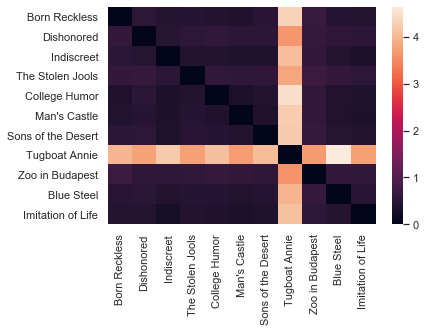

In [187]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

C:\Users\Thinkpad\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


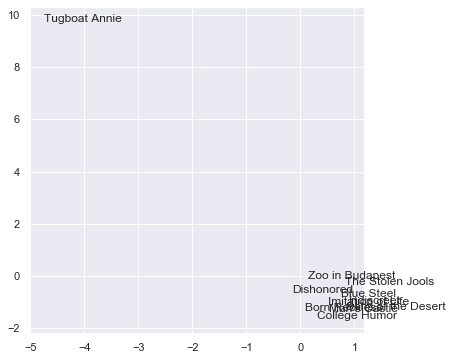

In [188]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

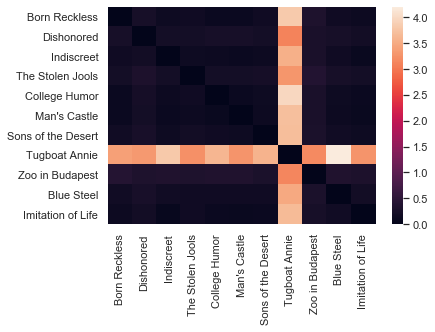

In [189]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\Thinkpad\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


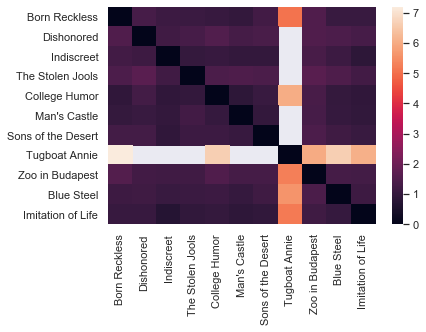

In [190]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

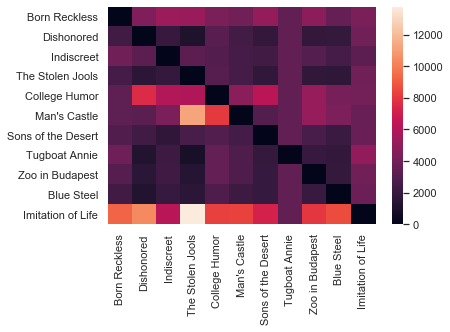

In [191]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

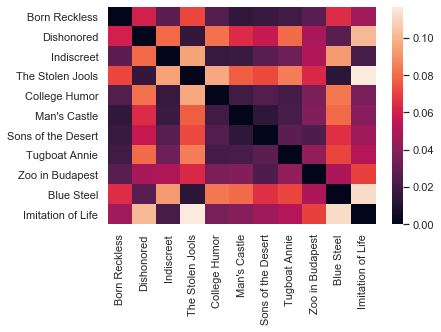

In [192]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

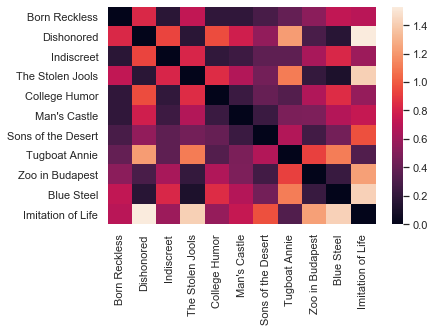

In [193]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

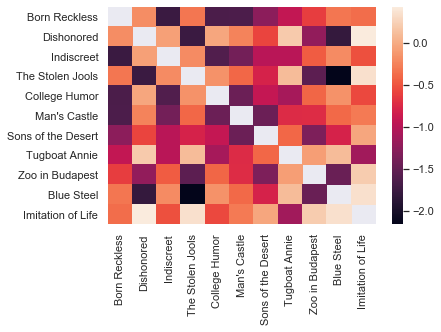

In [194]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [195]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [196]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

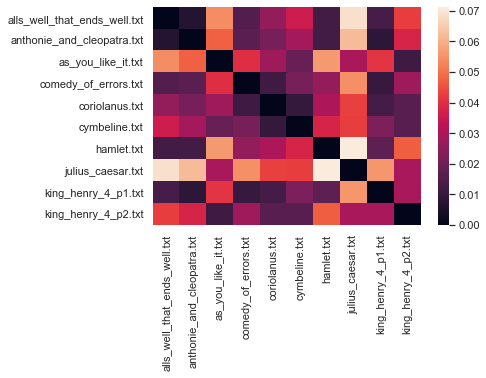

In [197]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 8*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In this exercise I will use the Minutes on Mar. 21, 2007, May 9, 2007, Mar. 18, 2009, and Apr. 29, 2009 as the four seperate corpora. However, I need to reload the data into a new dataframe because the dataframe constructed before is divided by paragraphs. Here I need to divide it by Minutes.

In [198]:
# Write a funtion to select the Minutes, seperate them, delete \n and \t, and convert them into a dataframe
def load_corpus_to_df_dbc(corpus_name, df):
    if corpus_name == Minutes_pre_txt:
        for file in os.listdir(corpus_name + "/"):
            if file in ['text_20070321.txt', 'text_20070509.txt']:
                Minutes_whole = []
                with open(corpus_name + '/' + file, encoding="utf8", errors='ignore') as f:
                    for line in f:
                        line_clean = line.replace('\n', '').replace('\t', ' ')
                        if line_clean:
                            Minutes_whole.append(line_clean)
                df = df.append({'source': file[:-4], 'text': ' '.join(Minutes_whole)}, ignore_index=True)
    else:
        for file in os.listdir(corpus_name + "/"):
            if file in ['text_20090318.txt', 'text_20090429.txt']:
                Minutes_whole = []
                with open(corpus_name + '/' + file, encoding="utf8", errors='ignore') as f:
                    for line in f:
                        line_clean = line.replace('\n', '').replace('\t', ' ')
                        if line_clean:
                            Minutes_whole.append(line_clean)
                df = df.append({'source': file[:-4], 'text': ' '.join(Minutes_whole)}, ignore_index=True)
    return df

In [199]:
# Construct the dataframe for pre-crisis Minutes
pre_df_dbc = pandas.DataFrame(columns = ["source", "text"])
pre_df_dbc = load_corpus_to_df_dbc(Minutes_pre_txt, pre_df_dbc)

post_df_dbc = pandas.DataFrame(columns = ["source", "text"])
post_df_dbc = load_corpus_to_df_dbc(Minutes_post_txt, post_df_dbc)

In [200]:
# Tokenize the texts and append two dataframes together
pre_df_dbc['tokenized_text'] = pre_df_dbc['text'].apply(lambda x: word_tokenize(x))
post_df_dbc['tokenized_text'] = post_df_dbc['text'].apply(lambda x: word_tokenize(x))
df_dbc = pre_df_dbc.append(post_df_dbc, ignore_index=True)
df_dbc

,source,text,tokenized_text
0,text_20070321,The Manager of the System Open Market Account ...,"[The, Manager, of, the, System, Open, Market, ..."
1,text_20070509,The Manager of the System Open Market Account ...,"[The, Manager, of, the, System, Open, Market, ..."
2,text_20090318,Developments in Financial Markets and the Fede...,"[Developments, in, Financial, Markets, and, th..."
3,text_20090429,Developments in Financial Markets and the Fede...,"[Developments, in, Financial, Markets, and, th..."


In [201]:
# Combine the corpora and seperate the texts into stop words and non-stop words
Minutes_corpora = []
for index, row in df_dbc.iterrows():
    Minutes_corpora.append(row['tokenized_text'])

Minutes_s = []
Minutes_nons = []
for corpus in Minutes_corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    Minutes_s.append(s)
    Minutes_nons.append(nons)

In [202]:
# Set the file ids
fileids = list(df_dbc['source'])

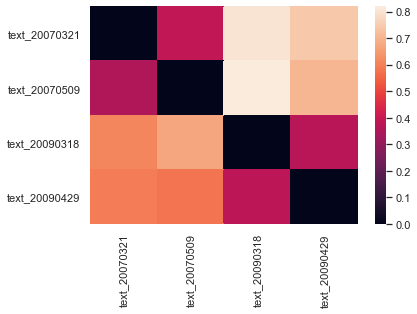

In [203]:
# Calculate the KL divergence for each pair on nonstop-words
L = []
for p in Minutes_nons:
    l = []
    for q in Minutes_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
M
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

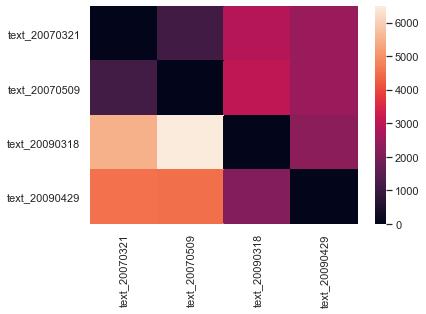

In [204]:
# Calculate the Chi2 divergence for each pair on nonstop-words
L = []
for p in Minutes_nons:
    l = []
    for q in Minutes_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
M
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

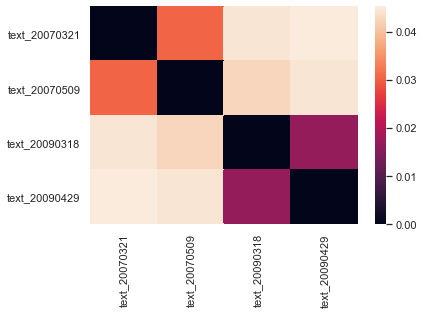

In [205]:
# Calculate the KS distance for each pair on nonstop-words
L = []
for p in Minutes_nons:
    l = []
    for q in Minutes_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
M
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

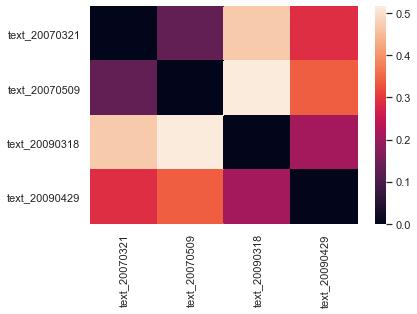

In [206]:
# Calculate the Wasserstein distance for each pair on nonstop-words
L = []
for p in Minutes_nons:
    l = []
    for q in Minutes_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
M
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

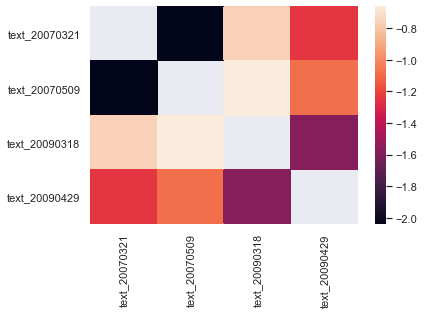

In [207]:
# Take logs of the Wasserstein distance
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

### Summary for divergence and distance calculation
No matter which measure we use to examine the similarity between texts, we could always find that the upper right and the lower left pairs are more divergent. This indicates that pre-crisis Minutes are more similar to pre-crisis ones, post-crisis Minutes are more similar to post-crisis ones, and pre-crisis Minutes look much more different from post-crisis ones. This pattern implies that the central bankers are shifting their focus after the crisis. In the corpora that I choose to analysis, distance does better than divergence because the contrast between pre-crisis Minutes and post-crisis Minutes becomes more obvious.

In [208]:
# Define functions to calculate Jensen-Shannon divergence
def js_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    m = (p + q) / 2
    D_js = scipy.stats.entropy(p, m) / 2 + scipy.stats.entropy(q, m) / 2
    return D_js

def Divergence_ext(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "JS":
        return js_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

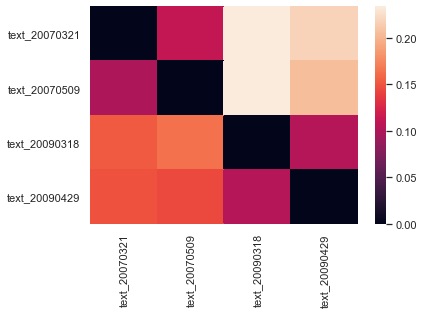

In [209]:
# Calculate the Wasserstein distance for each pair on nonstop-words
L = []
for p in Minutes_nons:
    l = []
    for q in Minutes_nons:
        l.append(Divergence_ext(p,q, difference='JS'))
    L.append(l)
M = np.array(L)
M
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### Summary for Jensen-Shannon divergence
Since JS divergence is just the symmetric and smooth version of KL divergence, they should look similar to each other. This pattern is well illustrated in the above analyses.